# “Анализ на големи данни за прецизната медицина”
## ТЕМА: “РАК НА БЕЛИЯ ДРОБ”
###Разработил: Анна- Мария Атанасова 961323002


# Import Packages

In [ ]:

from google.colab import drive
import os

import cv2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Construct Filepath image to dataframe

In [ ]:
#import data


# Mount Google Drive
drive.mount('/content/drive')



benign_dirs = [
    r'/content/drive/My Drive/Colab Notebooks/med/data/The IQ-OTHNCCD lung cancer dataset/Bengin cases'
]

Malignant_dir = [ r'/content/drive/My Drive/Colab Notebooks/med/data/The IQ-OTHNCCD lung cancer dataset/Malignant cases']

Normal_dirs = [
    r'/content/drive/My Drive/Colab Notebooks/med/data/The IQ-OTHNCCD lung cancer dataset/Normal cases'
]

filepaths = []
labels = []
dict_lists = [benign_dirs, Malignant_dir, Normal_dirs]
class_labels = ['benign', 'Malignant', 'Normal']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
Lung_data = pd.concat([Fseries, Lseries], axis=1)
Lung_df = pd.DataFrame(Lung_data)
print(Lung_df.head())
print(Lung_df["labels"].value_counts())

Mounted at /content/drive
                                           filepaths  labels
0  /content/drive/My Drive/Colab Notebooks/med/da...  benign
1  /content/drive/My Drive/Colab Notebooks/med/da...  benign
2  /content/drive/My Drive/Colab Notebooks/med/da...  benign
3  /content/drive/My Drive/Colab Notebooks/med/da...  benign
4  /content/drive/My Drive/Colab Notebooks/med/da...  benign
labels
Malignant    561
Normal       416
benign       120
Name: count, dtype: int64


In [ ]:
Lung_df.shape

(1097, 2)

# Statistical Analysis

## Visualization Image

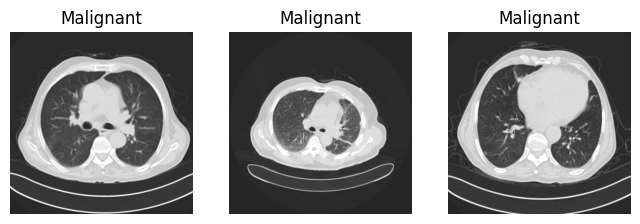

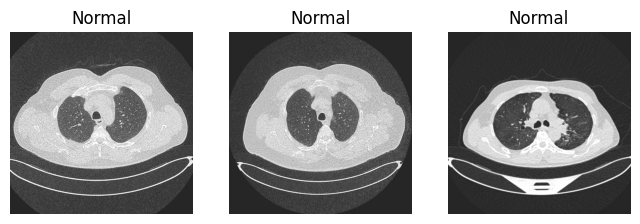

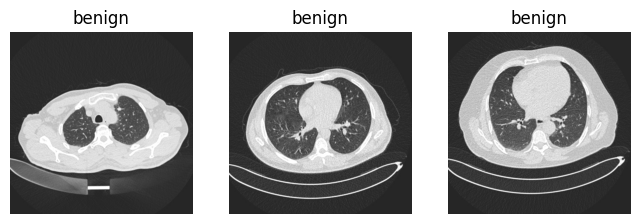

In [ ]:
for category, group in Lung_df.groupby("labels"):
    fig, ax = plt.subplots(1,3, figsize = (8,8))
    ax = ax.ravel()
    for i, (_,r) in enumerate(group.sample(3).iterrows()):
        img = cv2.imread(r.filepaths)
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title(r.labels)
    plt.show()

## Exploratory Data Analysis

### Occurrences of each label

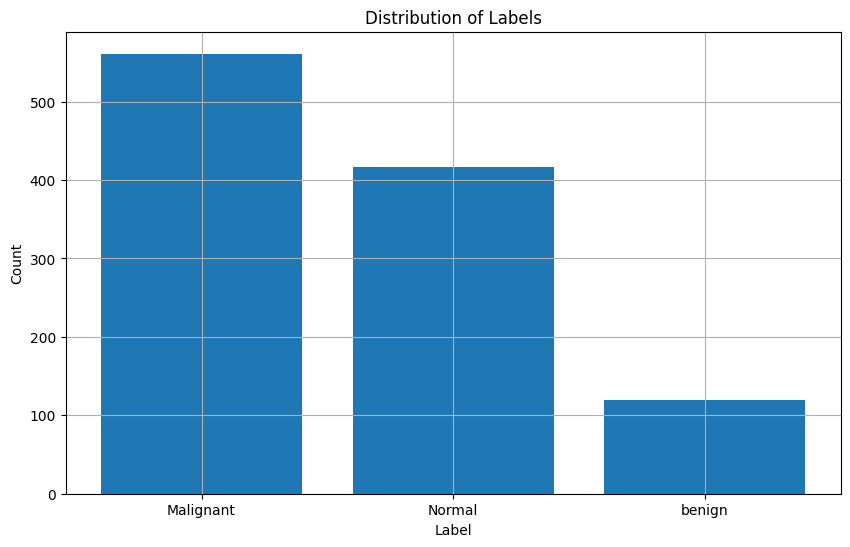

In [ ]:
# Count the occurrences of each label
count_data = Lung_df["labels"].value_counts().reset_index()

# Rename the columns for clarity
count_data.columns = ['labels', 'count']

# Plot the bar chart using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(count_data['labels'], count_data['count'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.grid(True)
plt.show()

### Heatmap

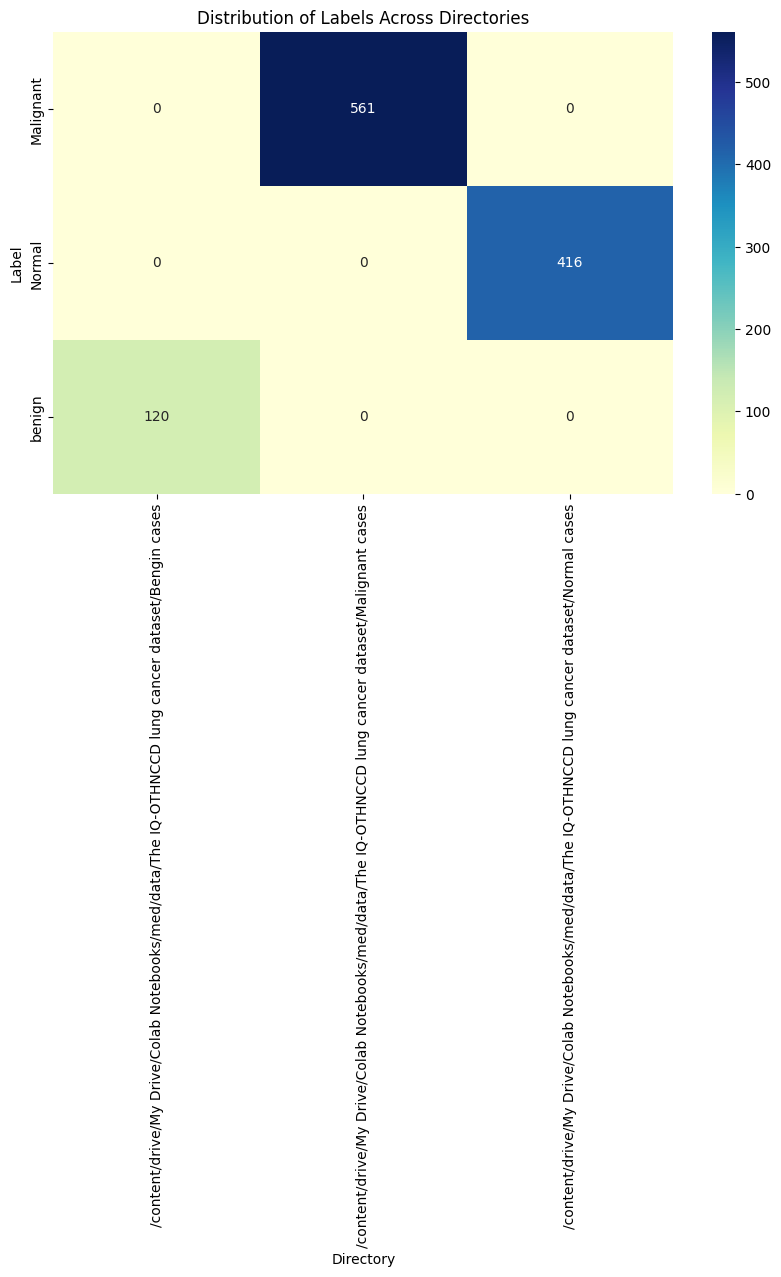

In [ ]:
# Convert to DataFrame
Lung_df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Extract directory names for better visualization
Lung_df['directory'] = Lung_df['filepaths'].apply(lambda x: os.path.dirname(x))

# Create a pivot table
pivot_table = Lung_df.pivot_table(index='labels', columns='directory', aggfunc='size', fill_value=0)

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Distribution of Labels Across Directories')
plt.xlabel('Directory')
plt.ylabel('Label')
plt.show()


## Extract Image Properties (Size, Resolution, Color Distribution)

In [ ]:
sizes = []
resolutions = []
color_distributions = []

for img_path in Lung_df["filepaths"]:
    #load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Get image size
    size = os.path.getsize(img_path)
    sizes.append(size)
    #Extract the resolution of images
    resolution = img.shape[:2]
    resolutions.append(resolution)
    #Extract color distribution
    mean_color_distributions = np.bincount(img.flatten(), minlength = 256)
    color_distributions.append(mean_color_distributions)
sizes = np.array(sizes)
resolutions = np.array(resolutions)
color_distributions = np.array(color_distributions)

### Size



####in bytes

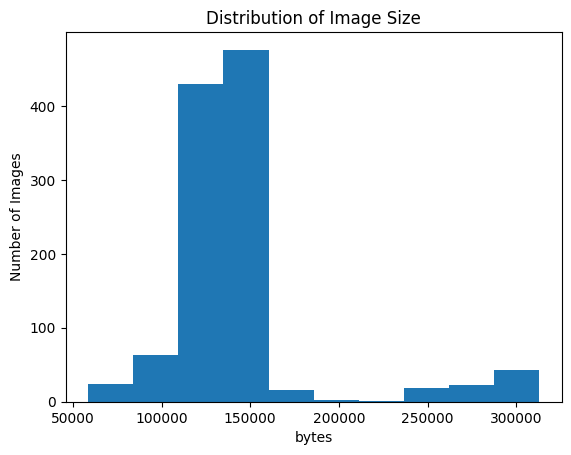

In [ ]:
plt.hist(sizes)
plt.title("Distribution of Image Size")
plt.xlabel("bytes")
plt.ylabel("Number of Images")
plt.show()

####in MB

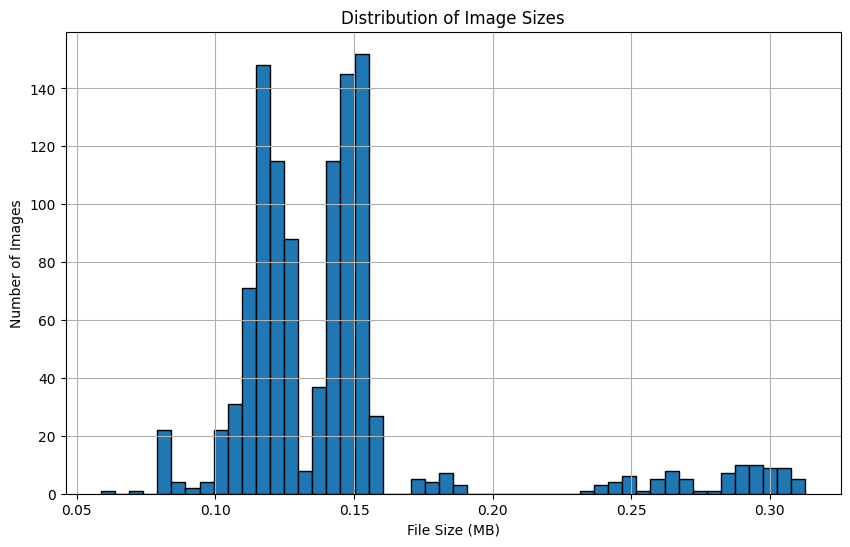

In [ ]:
#Sizes in MB
sizes_MB = []
for img_path in Lung_df["filepaths"]:
    #load image
    img = cv2.imread(img_path)
    #Get image size
    size = os.path.getsize(img_path)
    sizes_MB.append(size/1_000_000)

# Create a histogram using Matplotlib
plt.figure(figsize=(10, 6))
plt.hist(sizes_MB, bins=50, edgecolor='black')
plt.title("Distribution of Image Sizes")
plt.xlabel("File Size (MB)")
plt.ylabel("Number of Images")
plt.grid(True)
plt.show()

###Resolution

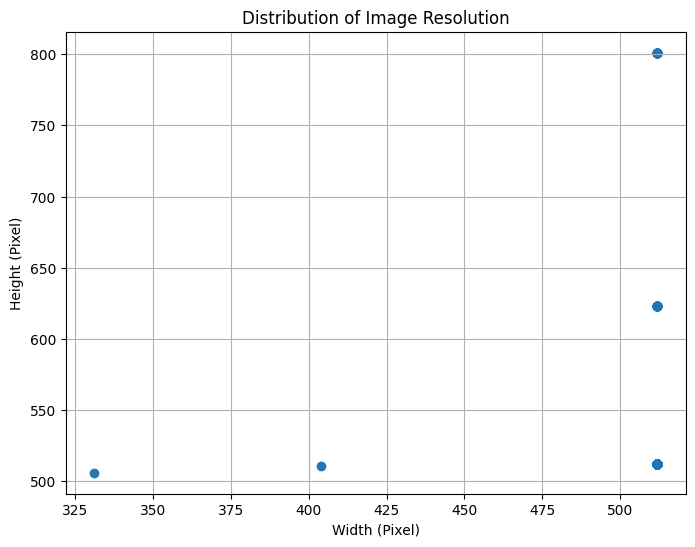

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(resolutions[:, 0], resolutions[:, 1])
plt.title("Distribution of Image Resolution")
plt.xlabel("Width (Pixel)")
plt.ylabel("Height (Pixel)")
plt.grid(True)
plt.show()

###Color Distribution

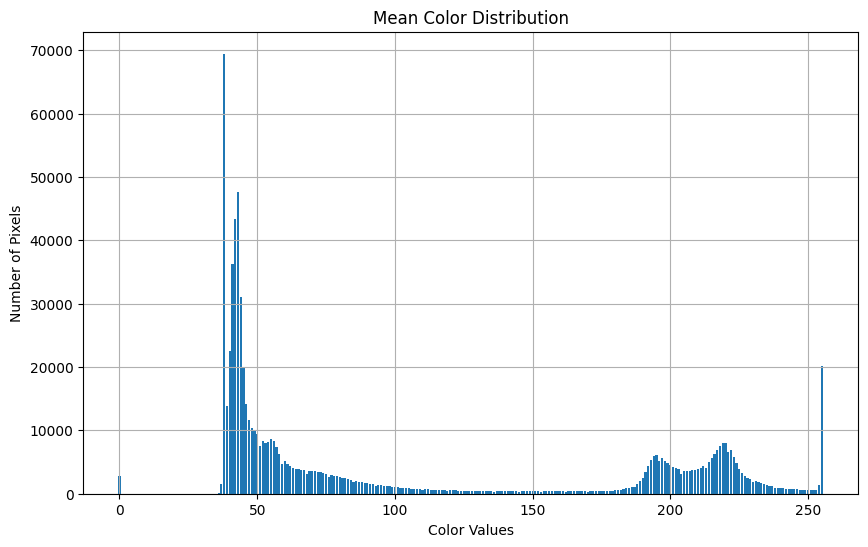

In [ ]:
mean_color_distributions = np.mean(color_distributions, axis=0)

# Create a bar plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(np.arange(256), mean_color_distributions)
plt.title("Mean Color Distribution")
plt.xlabel("Color Values")
plt.ylabel("Number of Pixels")
plt.grid(True)
plt.show()

#Preprocessing

##Missing data

In [ ]:
# Function to check if an image is readable
def is_image_readable(filepath):
    try:
        img = Image.open(filepath)
        img.verify()  # Verify that it is, in fact, an image
        return True
    except (IOError, SyntaxError):
        return False


In [ ]:
# Filter out unreadable images
Lung_df['is_readable'] = Lung_df['filepaths'].apply(is_image_readable)
Lung_df = Lung_df[Lung_df['is_readable']]

In [ ]:
# Split the data again after filtering
train_images, test_images = train_test_split(Lung_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(train_images, test_size=0.2, random_state=42)

In [ ]:
# Remove the 'is_readable' column as it's no longer needed
train_set = train_set.drop(columns=['is_readable'])
test_images = test_images.drop(columns=['is_readable'])
val_set = val_set.drop(columns=['is_readable'])

## Feature Extraction and size normalization

In [ ]:
# Preprocessing and Data Augmentation
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

In [ ]:
# Flow from dataframe with target_size=(224, 224)
train = image_gen.flow_from_dataframe(dataframe=train_set, x_col="filepaths", y_col="labels",
                                      target_size=(224, 224),
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=4,
                                      shuffle=False)

test = image_gen.flow_from_dataframe(dataframe=test_images, x_col="filepaths", y_col="labels",
                                     target_size=(224, 224),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle=False)

val = image_gen.flow_from_dataframe(dataframe=val_set, x_col="filepaths", y_col="labels",
                                    target_size=(224, 224),
                                    color_mode='rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False)

Found 613 validated image filenames belonging to 3 classes.
Found 330 validated image filenames belonging to 3 classes.
Found 154 validated image filenames belonging to 3 classes.


In [ ]:
# Load pre-trained MobileNetV2 model + higher level layers with target_size=(224, 224)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
# Extract features using MobileNetV2
def extract_features(generator, model):
    features = model.predict(generator, steps=len(generator), verbose=1)
    return features

In [ ]:
train_features = extract_features(train, base_model)
test_features = extract_features(test, base_model)
val_features = extract_features(val, base_model)

39/39 [==============================] - 8s 203ms/step


In [ ]:
# Flatten the features
train_features_flat = train_features.reshape((train_features.shape[0], -1))
test_features_flat = test_features.reshape((test_features.shape[0], -1))
val_features_flat = val_features.reshape((val_features.shape[0], -1))

In [ ]:
# Get the labels
train_labels = train.labels
test_labels = test.labels
val_labels = val.labels

In [ ]:
# Verify the number of samples
assert len(train_features_flat) == len(train_labels), "Mismatch in number of training features and labels"
assert len(test_features_flat) == len(test_labels), "Mismatch in number of testing features and labels"
assert len(val_features_flat) == len(val_labels), "Mismatch in number of validation features and labels"

#Training and Validation

## SVM Model

In [ ]:
# Train the SVM
svm_model = SVC(kernel='linear')
svm_model.fit(train_features_flat, train_labels)

SVC(kernel='linear')

In [ ]:
# Predict
test_predictions_svm = svm_model.predict(test_features_flat)

## CNN model

In [ ]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # Adjust the number of units to match the number of classes
])

In [ ]:
# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = cnn_model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
154/154 [==============================] - 264s 2s/step - loss: 0.8947 - accuracy: 0.6786 - val_loss: 0.4123 - val_accuracy: 0.8831
Epoch 2/10
154/154 [==============================] - 263s 2s/step - loss: 0.2407 - accuracy: 0.9184 - val_loss: 0.1735 - val_accuracy: 0.9481
Epoch 3/10
154/154 [==============================] - 280s 2s/step - loss: 0.0941 - accuracy: 0.9739 - val_loss: 0.0936 - val_accuracy: 0.9805
Epoch 4/10
154/154 [==============================] - 271s 2s/step - loss: 0.0559 - accuracy: 0.9821 - val_loss: 0.0766 - val_accuracy: 0.9740
Epoch 5/10
154/154 [==============================] - 278s 2s/step - loss: 0.0418 - accuracy: 0.9853 - val_loss: 0.0946 - val_accuracy: 0.9805
Epoch 6/10
154/154 [==============================] - 273s 2s/step - loss: 0.0289 - accuracy: 0.9935 - val_loss: 0.0678 - val_accuracy: 0.9740
Epoch 7/10
154/154 [==============================] - 280s 2s/step - loss: 0.0079 - accuracy: 0.9984 - val_loss: 0.0501 - val_accuracy: 0.9870

In [ ]:
# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(test)
print(f"Test accuracy: {test_acc}")

83/83 [==============================] - 15s 178ms/step - loss: 0.1260 - accuracy: 0.9727
Test accuracy: 0.9727272987365723


In [ ]:
# Predict
test_predictions_cnn = cnn_model.predict(test)
test_predictions_cnn = np.argmax(test_predictions_cnn, axis=1)
true_labels = test.labels

83/83 [==============================] - 15s 174ms/step


## Confusion Matrix

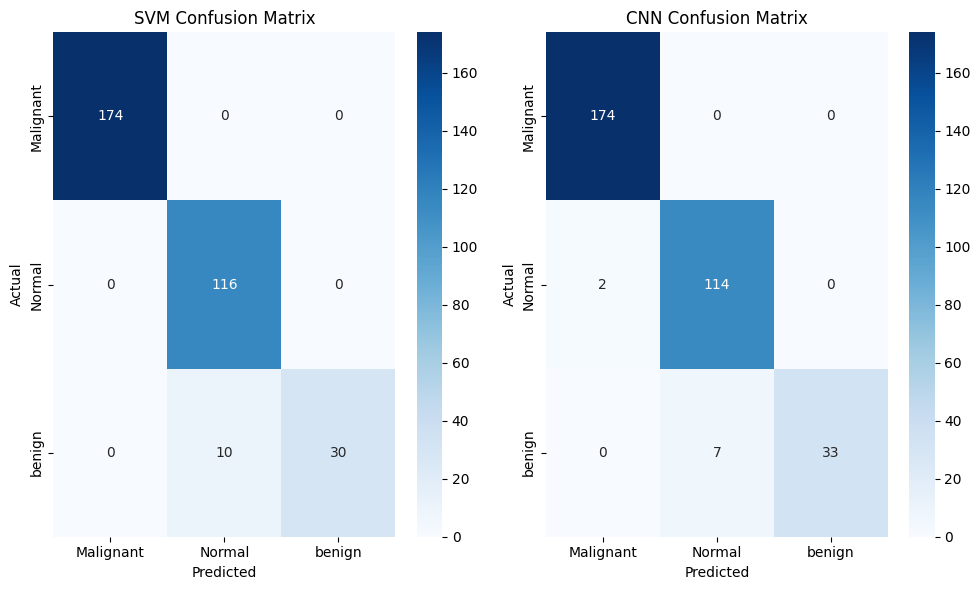

In [ ]:
# Confusion Matrix SVM
conf_matrix_svm = confusion_matrix(test_labels, test_predictions_svm)

# Confusion Matrix CNN
conf_matrix_cnn = confusion_matrix(true_labels, test_predictions_cnn)

# Labels for the confusion matrix
labels = ['Actual Positive', 'Actual Negative']
predictions = ['Predicted Positive', 'Predicted Negative']

# Plot SVM confusion matrix
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=train.class_indices.keys(), yticklabels=train.class_indices.keys())
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot CNN confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=train.class_indices.keys(), yticklabels=train.class_indices.keys())
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

## PAS (Precision, Accuracy, Sensitivity)


SVM Model PAS Metrics:
Precision (Macro-Averaged): 0.9735
Recall (Macro-Averaged): 0.9167
Accuracy: 0.9697

CNN Model PAS Metrics:
Precision (Macro-Averaged): 0.9769
Recall (Macro-Averaged): 0.9359
Accuracy: 0.9727


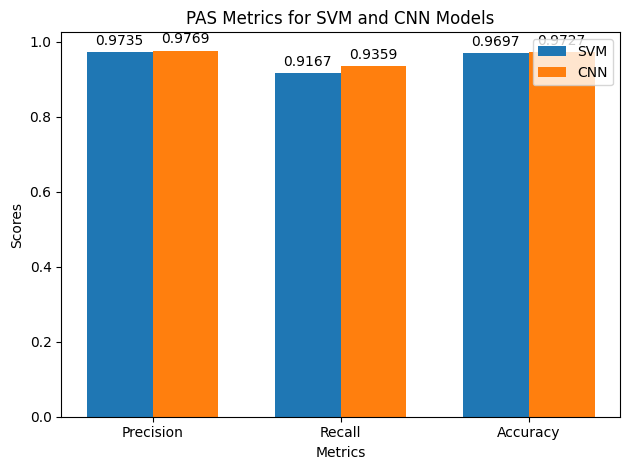

In [ ]:
# Function to calculate PAS metrics
def calculate_pas_metrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    num_classes = conf_matrix.shape[0]
    precisions = []
    recalls = []

    for i in range(num_classes):
        TP = conf_matrix[i, i]
        FP = conf_matrix[:, i].sum() - TP
        FN = conf_matrix[i, :].sum() - TP
        TN = conf_matrix.sum() - (TP + FP + FN)

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)

    macro_precision = np.mean(precisions)
    macro_recall = np.mean(recalls)
    accuracy = accuracy_score(y_true, y_pred)

    return macro_precision, macro_recall, accuracy

# Calculate PAS metrics for both models
svm_precision, svm_recall, svm_accuracy = calculate_pas_metrics(test_labels, test_predictions_svm)
cnn_precision, cnn_recall, cnn_accuracy = calculate_pas_metrics(true_labels, test_predictions_cnn)

# Print PAS metrics
print(f'SVM Model PAS Metrics:')
print(f'Precision (Macro-Averaged): {svm_precision:.4f}')
print(f'Recall (Macro-Averaged): {svm_recall:.4f}')
print(f'Accuracy: {svm_accuracy:.4f}')

print(f'\nCNN Model PAS Metrics:')
print(f'Precision (Macro-Averaged): {cnn_precision:.4f}')
print(f'Recall (Macro-Averaged): {cnn_recall:.4f}')
print(f'Accuracy: {cnn_accuracy:.4f}')

# Plot PAS metrics
metrics = ['Precision', 'Recall', 'Accuracy']
svm_scores = [svm_precision, svm_recall, svm_accuracy]
cnn_scores = [cnn_precision, cnn_recall, cnn_accuracy]

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, svm_scores, width, label='SVM')
rects2 = ax.bar(x + width/2, cnn_scores, width, label='CNN')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('PAS Metrics for SVM and CNN Models')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

##Classification Report

In [ ]:
# Classification Report
print(f'SVM Model Classification Report:')
print(classification_report(test_labels, test_predictions_svm, target_names=train.class_indices.keys()))

print(f'\nCNN Model Classification Report:')
print(classification_report(true_labels, test_predictions_cnn, target_names=train.class_indices.keys()))

SVM Model Classification Report:
              precision    recall  f1-score   support

   Malignant       1.00      1.00      1.00       174
      Normal       0.92      1.00      0.96       116
      benign       1.00      0.75      0.86        40

    accuracy                           0.97       330
   macro avg       0.97      0.92      0.94       330
weighted avg       0.97      0.97      0.97       330


CNN Model Classification Report:
              precision    recall  f1-score   support

   Malignant       0.99      1.00      0.99       174
      Normal       0.94      0.98      0.96       116
      benign       1.00      0.82      0.90        40

    accuracy                           0.97       330
   macro avg       0.98      0.94      0.95       330
weighted avg       0.97      0.97      0.97       330

